In [2]:
### Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import keras
import os
import datetime
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D, Dense, Flatten, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

### This notebook is designed using co-lab, please ensure the correct folder is in the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
root = '/content/drive/MyDrive/Assignment/glucose'

## parsing training data

In [5]:
normalize_para = 100
fwin = 30
BW = 250
import xml.etree.ElementTree as ET
uids = [540, 544, 552, 567, 584, 596] 
  # loop for all uids
patients_glucose = []
patients_bolus_time = []
patients_bolus_dose = []
finger_stick = []
patients_meal = []
patients_basal = []

for uid in uids:
  # parse .xml file
    tree = ET.parse(f'/content/drive/MyDrive/Assignment/glucose/Training/{uid}-ws-training.xml')
      # get the root of the content tree which contains all the data of a patient
    root = tree.getroot()
      # get all values of the attribute <glucose_level> from the tree
    glucose_level_and_time_elements = [e for e in root.find(
        'glucose_level').findall('event')]
      # generate a dictionary whose keys and values are time and glucose levels respectively
    time_glucose_level_dict = dict([(datetime.datetime.strptime(el.attrib['ts'], '%d-%m-%Y %H:%M:%S'),float(el.attrib['value'])) for el in glucose_level_and_time_elements])
    patients_glucose.append(time_glucose_level_dict)
    
    bolus_info = [e for e in root.find('bolus').findall('event')]
    bolus_info_dict_timespan = dict([(datetime.datetime.strptime(el.attrib['ts_begin'], '%d-%m-%Y %H:%M:%S'),
                             datetime.datetime.strptime(el.attrib['ts_end'], '%d-%m-%Y %H:%M:%S')) for el in bolus_info])
    patients_bolus_time.append(bolus_info_dict_timespan)
    bolus_info_dict_dose = dict([(datetime.datetime.strptime(el.attrib['ts_begin'], '%d-%m-%Y %H:%M:%S'),
                             float(el.attrib['dose'])) for el in bolus_info])
    patients_bolus_dose.append(bolus_info_dict_dose)
    
    meal_info = [e for e in root.find('meal').findall('event')]
    meal_dict = dict([(datetime.datetime.strptime(el.attrib['ts'], '%d-%m-%Y %H:%M:%S'),int(el.attrib['carbs'])) for el in meal_info])
    patients_meal.append(meal_dict)
    
    basal_info = [e for e in root.find('basal').findall('event')]
    basal_dict = dict([(datetime.datetime.strptime(el.attrib['ts'], '%d-%m-%Y %H:%M:%S'),float(el.attrib['value'])) for el in basal_info])
    patients_basal.append(basal_dict)

## parsing testing data

In [6]:
uids = [540, 544, 552, 567, 584, 596] 
  # loop for all uids
patients_glucose_test = []
patients_bolus_time_test = []
patients_bolus_dose_test = []
finger_stick_test = []
patients_meal_test = []
patients_basal_test = []

for uid in uids:
  # parse .xml file
    tree = ET.parse(f'/content/drive/MyDrive/Assignment/glucose/Testing/{uid}-ws-testing.xml')
      # get the root of the content tree which contains all the data of a patient
    root = tree.getroot()
      # get all values of the attribute <glucose_level> from the tree
    glucose_level_and_time_elements_test = [e for e in root.find(
        'glucose_level').findall('event')]
      # generate a dictionary whose keys and values are time and glucose levels respectively
    time_glucose_level_dict_test = dict([(datetime.datetime.strptime(el.attrib['ts'], '%d-%m-%Y %H:%M:%S'),float(el.attrib['value'])) for el in glucose_level_and_time_elements_test])
    patients_glucose_test.append(time_glucose_level_dict_test)
    
    bolus_info_test = [e for e in root.find('bolus').findall('event')]
    bolus_info_dict_timespan_test = dict([(datetime.datetime.strptime(el.attrib['ts_begin'], '%d-%m-%Y %H:%M:%S'),
                             datetime.datetime.strptime(el.attrib['ts_end'], '%d-%m-%Y %H:%M:%S')) for el in bolus_info_test])
    patients_bolus_time_test.append(bolus_info_dict_timespan_test)
    bolus_info_dict_dose_test = dict([(datetime.datetime.strptime(el.attrib['ts_begin'], '%d-%m-%Y %H:%M:%S'),
                             float(el.attrib['dose'])) for el in bolus_info_test])
    patients_bolus_dose_test.append(bolus_info_dict_dose_test)
    
    meal_info_test = [e for e in root.find('meal').findall('event')]
    meal_dict_test = dict([(datetime.datetime.strptime(el.attrib['ts'], '%d-%m-%Y %H:%M:%S'),int(el.attrib['carbs'])) for el in meal_info_test])
    patients_meal_test.append(meal_dict_test)
    
    basal_info_test = [e for e in root.find('basal').findall('event')]
    basal_dict_test = dict([(datetime.datetime.strptime(el.attrib['ts'], '%d-%m-%Y %H:%M:%S'),float(el.attrib['value'])) for el in basal_info_test])
    patients_basal_test.append(basal_dict_test)

## formatting data into dataframes

In [7]:
#patients have been added iteratively for easy access

Glucose (interpolated)

In [8]:
pat_glucose_list_of_lists = [0,1,2,3,4,5]
# create list of lists with access to all patients items
for i in range(len(patients_glucose)):
  pat_glucose_list_of_lists[i] = patients_glucose[i].items()
  pat_glucose_list_of_lists[i] = [list(elem) for elem in pat_glucose_list_of_lists[i]]
# add 5 minute intervals
for i in range(len(pat_glucose_list_of_lists)):
  for j in range(len(pat_glucose_list_of_lists[i])):
    pat_glucose_list_of_lists[i][j].append(5*j)
# create zero-time for later use on other variables
tzeros = []
for i in range(len(pat_glucose_list_of_lists)):
  tzeros.append(pat_glucose_list_of_lists[i][0][0])
# remove datetimes
for i in range(len(pat_glucose_list_of_lists)):
  for j in range(len(pat_glucose_list_of_lists[i])):
    pat_glucose_list_of_lists[i][j].remove(pat_glucose_list_of_lists[i][j][0])

#insert space for interpolation
missing = [np.nan,0]
for i in range(len(pat_glucose_list_of_lists)):
    initial_size = len(pat_glucose_list_of_lists[i])
    current_insertion_index = 1
    p = 0
    # - 1 because we don't want it after last element too
    while p < initial_size - 1:
      pat_glucose_list_of_lists[i].insert(current_insertion_index,missing)
      pat_glucose_list_of_lists[i].insert(current_insertion_index,missing)
      pat_glucose_list_of_lists[i].insert(current_insertion_index,missing)
      pat_glucose_list_of_lists[i].insert(current_insertion_index,missing)
      current_insertion_index += 5
      p += 1
train_dataframes = [pd.DataFrame(pat_glucose_list_of_lists[0],columns=['glucose','time']),pd.DataFrame(pat_glucose_list_of_lists[1],columns=['glucose','time']),
                pd.DataFrame(pat_glucose_list_of_lists[2],columns=['glucose','time']),pd.DataFrame(pat_glucose_list_of_lists[3],columns=['glucose','time']),
                pd.DataFrame(pat_glucose_list_of_lists[4],columns=['glucose','time']),pd.DataFrame(pat_glucose_list_of_lists[5],columns=['glucose','time'])]
for i in range(len(train_dataframes)):
  train_dataframes[i]['glucose']=train_dataframes[i]['glucose'].interpolate()
  train_dataframes[i]['time'] = range(0,len(train_dataframes[i]))

#####################################################################################################################################################################
#test data
#####################################################################################################################################################################

pat_glucose_list_of_lists_test = [0,1,2,3,4,5]
# create list of lists with access to all patients items
for i in range(len(patients_glucose_test)):
  pat_glucose_list_of_lists_test[i] = patients_glucose_test[i].items()
  pat_glucose_list_of_lists_test[i] = [list(elem) for elem in pat_glucose_list_of_lists_test[i]]
# add 5 minute intervals
for i in range(len(pat_glucose_list_of_lists_test)):
  for j in range(len(pat_glucose_list_of_lists_test[i])):
    pat_glucose_list_of_lists_test[i][j].append(5*j)
# create zero-time for later use on other variables
tzeros_test = []
for i in range(len(pat_glucose_list_of_lists_test)):
  tzeros_test.append(pat_glucose_list_of_lists_test[i][0][0])
# remove datetimes
for i in range(len(pat_glucose_list_of_lists_test)):
  for j in range(len(pat_glucose_list_of_lists_test[i])):
    pat_glucose_list_of_lists_test[i][j].remove(pat_glucose_list_of_lists_test[i][j][0])

#insert space for interpolation
missing = [np.nan,0]
for i in range(len(pat_glucose_list_of_lists_test)):
    initial_size_test = len(pat_glucose_list_of_lists_test[i])
    current_insertion_index = 1
    p = 0
    # - 1 because we don't want it after last element too
    while p < initial_size_test - 1:
      pat_glucose_list_of_lists_test[i].insert(current_insertion_index,missing)
      pat_glucose_list_of_lists_test[i].insert(current_insertion_index,missing)
      pat_glucose_list_of_lists_test[i].insert(current_insertion_index,missing)
      pat_glucose_list_of_lists_test[i].insert(current_insertion_index,missing)
      current_insertion_index += 5
      p += 1
dataframes_test = [pd.DataFrame(pat_glucose_list_of_lists_test[0],columns=['glucose','time']),pd.DataFrame(pat_glucose_list_of_lists_test[1],columns=['glucose','time']),
                pd.DataFrame(pat_glucose_list_of_lists_test[2],columns=['glucose','time']),pd.DataFrame(pat_glucose_list_of_lists_test[3],columns=['glucose','time']),
                pd.DataFrame(pat_glucose_list_of_lists_test[4],columns=['glucose','time']),pd.DataFrame(pat_glucose_list_of_lists_test[5],columns=['glucose','time'])]
for i in range(len(dataframes_test)):
  dataframes_test[i]['glucose']=dataframes_test[i]['glucose'].interpolate()
  dataframes_test[i]['time'] = range(0,len(dataframes_test[i]))

Bolus

In [9]:
bolus_list_of_lists = [0,1,2,3,4,5]
# create list of lists with access to all patients items
for i in range(len(patients_bolus_dose)):
  bolus_list_of_lists[i] = patients_bolus_dose[i].items()
  bolus_list_of_lists[i] =[list(elem) for elem in bolus_list_of_lists[i]]
for i in range(len(bolus_list_of_lists)):
    for j in range(len(bolus_list_of_lists[i])):
      bolus_list_of_lists[i][j][0] = bolus_list_of_lists[i][j][0]-tzeros[i]
      bolus_list_of_lists[i][j][0] = bolus_list_of_lists[i][j][0].total_seconds()
      bolus_list_of_lists[i][j][0] = round(bolus_list_of_lists[i][j][0]/60)
new_list = []
for i in bolus_list_of_lists:
    new = []
    for j in i:
        if j[0] < 0:
            continue
        else:
            new.append(j)

    new_list.append(new)
train_dataframes_bolus = [pd.DataFrame(new_list[0],columns=['time','dose']),pd.DataFrame(new_list[1],columns=['time','dose']),
                pd.DataFrame(new_list[2],columns=['time','dose']),pd.DataFrame(new_list[3],columns=['time','dose']),
                pd.DataFrame(new_list[4],columns=['time','dose']),pd.DataFrame(new_list[5],columns=['time','dose'])]
counter = 0
for i in range(len(train_dataframes_bolus)):
  train_dataframes_bolus[i] = pd.merge(train_dataframes[counter],train_dataframes_bolus[i],
                                       left_on=['time'],how='left',right_on=[train_dataframes_bolus[i]['time']])
  train_dataframes_bolus[i].drop(['time_x','time_y'],axis=1,inplace=True)
  train_dataframes_bolus[i]['dose'].fillna(0,inplace=True)
  counter+=1

#####################################################################################################################################################################
#test data
#####################################################################################################################################################################

bolus_list_of_lists_test = [0,1,2,3,4,5]
# create list of lists with access to all patients items
for i in range(len(patients_bolus_dose_test)):
  bolus_list_of_lists_test[i] = patients_bolus_dose_test[i].items()
  bolus_list_of_lists_test[i] =[list(elem) for elem in bolus_list_of_lists_test[i]]
for i in range(len(bolus_list_of_lists_test)):
    for j in range(len(bolus_list_of_lists_test[i])):
      bolus_list_of_lists_test[i][j][0] = bolus_list_of_lists_test[i][j][0]-tzeros_test[i]
      bolus_list_of_lists_test[i][j][0] = bolus_list_of_lists_test[i][j][0].total_seconds()
      bolus_list_of_lists_test[i][j][0] = round(bolus_list_of_lists_test[i][j][0]/60)
new_list_test = []
for i in bolus_list_of_lists_test:
    new_test = []
    for j in i:
        if j[0] < 0:
            continue
        else:
            new_test.append(j)

    new_list_test.append(new)
dataframes_bolus_test = [pd.DataFrame(new_list_test[0],columns=['time','dose']),pd.DataFrame(new_list_test[1],columns=['time','dose']),
                pd.DataFrame(new_list_test[2],columns=['time','dose']),pd.DataFrame(new_list_test[3],columns=['time','dose']),
                pd.DataFrame(new_list_test[4],columns=['time','dose']),pd.DataFrame(new_list_test[5],columns=['time','dose'])]
counter = 0
for i in range(len(dataframes_bolus_test)):
  dataframes_bolus_test[i] = pd.merge(dataframes_test[counter],dataframes_bolus_test[i],
                                       left_on=['time'],how='left',right_on=[dataframes_bolus_test[i]['time']])
  dataframes_bolus_test[i].drop(['time_x','time_y'],axis=1,inplace=True)
  dataframes_bolus_test[i]['dose'].fillna(0,inplace=True)
  counter+=1

meal/carbs

In [10]:
carbs_list_of_lists = [0,1,2,3,4,5]
for i in range(len(patients_meal)):
  carbs_list_of_lists[i] = patients_meal[i].items()
  carbs_list_of_lists[i] = [list(elem) for elem in carbs_list_of_lists[i]]
for i in range(len(carbs_list_of_lists)):
  for j in range(len(carbs_list_of_lists[i])):
    carbs_list_of_lists[i][j][0] = carbs_list_of_lists[i][j][0]-tzeros[i]
    carbs_list_of_lists[i][j][0] = carbs_list_of_lists[i][j][0].total_seconds()
    carbs_list_of_lists[i][j][0] = round(carbs_list_of_lists[i][j][0]/60)
new_list = []
for i in carbs_list_of_lists:
    new = []
    for j in i:
        if j[0] < 0:
            continue
        else:
            new.append(j)

    new_list.append(new)
train_dataframes_carbs = [pd.DataFrame(new_list[0],columns=['time','carbs']),pd.DataFrame(new_list[1],columns=['time','carbs']),
                pd.DataFrame(new_list[2],columns=['time','carbs']),pd.DataFrame(new_list[3],columns=['time','carbs']),
                pd.DataFrame(new_list[4],columns=['time','carbs']),pd.DataFrame(new_list[5],columns=['time','carbs'])]
counter = 0
for i in range(len(train_dataframes_carbs)):
  train_dataframes_carbs[i] = pd.merge(train_dataframes_bolus[counter],train_dataframes_carbs[i],
                                       left_on=['time'],how='left',right_on=[train_dataframes_carbs[i]['time']])
  train_dataframes_carbs[i].drop(['time_x','time_y'],axis=1,inplace=True)
  train_dataframes_carbs[i]['carbs'].fillna(0,inplace=True)
  counter+=1

#####################################################################################################################################################################
#test data
#####################################################################################################################################################################

carbs_list_of_lists_test = [0,1,2,3,4,5]
for i in range(len(patients_meal_test)):
  carbs_list_of_lists_test[i] = patients_meal_test[i].items()
  carbs_list_of_lists_test[i] = [list(elem) for elem in carbs_list_of_lists_test[i]]
for i in range(len(carbs_list_of_lists_test)):
  for j in range(len(carbs_list_of_lists_test[i])):
    carbs_list_of_lists_test[i][j][0] = carbs_list_of_lists_test[i][j][0]-tzeros[i]
    carbs_list_of_lists_test[i][j][0] = carbs_list_of_lists_test[i][j][0].total_seconds()
    carbs_list_of_lists_test[i][j][0] = round(carbs_list_of_lists_test[i][j][0]/60)
new_list_test = []
for i in carbs_list_of_lists_test:
    new_test = []
    for j in i:
        if j[0] < 0:
            continue
        else:
            new_test.append(j)

    new_list_test.append(new)
dataframes_carbs_test = [pd.DataFrame(new_list_test[0],columns=['time','carbs']),pd.DataFrame(new_list_test[1],columns=['time','carbs']),
                pd.DataFrame(new_list_test[2],columns=['time','carbs']),pd.DataFrame(new_list_test[3],columns=['time','carbs']),
                pd.DataFrame(new_list_test[4],columns=['time','carbs']),pd.DataFrame(new_list_test[5],columns=['time','carbs'])]
counter = 0
for i in range(len(dataframes_carbs_test)):
  dataframes_carbs_test[i] = pd.merge(dataframes_bolus_test[counter],dataframes_carbs_test[i],
                                        left_on=['time'],how='left',right_on=[dataframes_carbs_test[i]['time']])
  dataframes_carbs_test[i].drop(['time_x','time_y'],axis=1,inplace=True)
  dataframes_carbs_test[i]['carbs'].fillna(0,inplace=True)
  counter+=1

basal

In [11]:
basal_list_of_lists = [0,1,2,3,4,5]
for i in range(len(patients_basal)):
  basal_list_of_lists[i] = patients_basal[i].items()
  basal_list_of_lists[i] = [list(elem) for elem in basal_list_of_lists[i]]
for i in range(len(basal_list_of_lists)):
  for j in range(len(basal_list_of_lists[i])):
    basal_list_of_lists[i][j][0] = basal_list_of_lists[i][j][0]-tzeros[i]
    basal_list_of_lists[i][j][0] = basal_list_of_lists[i][j][0].total_seconds()
    basal_list_of_lists[i][j][0] = round(basal_list_of_lists[i][j][0]/60)
new_list = []
for i in basal_list_of_lists:
    new = []
    for j in i:
        if j[0] < 0:
            continue
        else:
            new.append(j)

    new_list.append(new)
train_dataframes_basal = [pd.DataFrame(new_list[0],columns=['time','basal']),pd.DataFrame(new_list[1],columns=['time','basal']),
                pd.DataFrame(new_list[2],columns=['time','basal']),pd.DataFrame(new_list[3],columns=['time','basal']),
                pd.DataFrame(new_list[4],columns=['time','basal']),pd.DataFrame(new_list[5],columns=['time','basal'])]
counter = 0
for i in range(len(train_dataframes_basal)):
  train_dataframes_basal[i] = pd.merge(train_dataframes_carbs[counter],train_dataframes_basal[i],
                                       left_on=['time'],how='left',right_on=[train_dataframes_basal[i]['time']])
  train_dataframes_basal[i].drop(['time_x','time_y'],axis=1,inplace=True)

  counter+=1
  for i in range(len(train_dataframes_basal)):
    train_dataframes_basal[i].basal.iloc[0] = 0.95
    train_dataframes_basal[i]['basal'].fillna(method='ffill',inplace=True)

#####################################################################################################################################################################
#test data
#####################################################################################################################################################################

basal_list_of_lists_test = [0,1,2,3,4,5]
for i in range(len(patients_basal_test)):
  basal_list_of_lists_test[i] = patients_basal_test[i].items()
  basal_list_of_lists_test[i] = [list(elem) for elem in basal_list_of_lists_test[i]]
for i in range(len(basal_list_of_lists_test)):
  for j in range(len(basal_list_of_lists_test[i])):
    basal_list_of_lists_test[i][j][0] = basal_list_of_lists_test[i][j][0]-tzeros_test[i]
    basal_list_of_lists_test[i][j][0] = basal_list_of_lists_test[i][j][0].total_seconds()
    basal_list_of_lists_test[i][j][0] = round(basal_list_of_lists_test[i][j][0]/60)
new_list = []
for i in basal_list_of_lists_test:
    new = []
    for j in i:
        if j[0] < 0:
            continue
        else:
            new.append(j)

    new_list.append(new)
dataframes_basal_test = [pd.DataFrame(new_list[0],columns=['time','basal']),pd.DataFrame(new_list[1],columns=['time','basal']),
                pd.DataFrame(new_list[2],columns=['time','basal']),pd.DataFrame(new_list[3],columns=['time','basal']),
                pd.DataFrame(new_list[4],columns=['time','basal']),pd.DataFrame(new_list[5],columns=['time','basal'])]
counter = 0
for i in range(len(dataframes_basal_test)):
  dataframes_basal_test[i] = pd.merge(dataframes_carbs_test[counter],dataframes_basal_test[i],
                                       left_on=['time'],how='left',right_on=[dataframes_basal_test[i]['time']])
  dataframes_basal_test[i].drop(['time_x','time_y'],axis=1,inplace=True)

  counter+=1
  for i in range(len(dataframes_basal_test)):
    dataframes_basal_test[i].basal.iloc[0] = 0.95
    dataframes_basal_test[i]['basal'].fillna(method='ffill',inplace=True)

In [12]:
from IPython.core.display import HTML 
# display function courtesy of https://github.com/epmoyer
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:grey;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )
multi_table([train_dataframes_basal[0],train_dataframes_basal[1],train_dataframes_basal[2],train_dataframes_basal[3],
             train_dataframes_basal[4],train_dataframes_basal[5]])

,time,glucose,dose,carbs,basal
0,0,76.0,0.0,0.0,0.95
1,1,75.2,0.0,0.0,0.95
2,2,74.4,0.0,0.0,0.95
3,3,73.6,0.0,0.0,0.95
4,4,72.8,0.0,0.0,0.95
...,...,...,...,...,...
59726,59726,256.6,0.0,0.0,0.40
59727,59727,256.2,0.0,0.0,0.40
59728,59728,255.8,0.0,0.0,0.40
59729,59729,255.4,0.0,0.0,0.40


In [13]:
multi_table([dataframes_basal_test[0],dataframes_basal_test[1],dataframes_basal_test[2],dataframes_basal_test[3],
             dataframes_basal_test[4],dataframes_basal_test[5]])

,time,glucose,dose,carbs,basal
0,0,254.0,0.0,0.0,0.95
1,1,253.2,0.0,0.0,0.95
2,2,252.4,0.0,0.0,0.95
3,3,251.6,0.0,0.0,0.95
4,4,250.8,0.0,0.0,0.95
...,...,...,...,...,...
14471,14471,246.8,0.0,0.0,0.40
14472,14472,245.6,0.0,0.0,0.40
14473,14473,244.4,0.0,0.0,0.40
14474,14474,243.2,0.0,0.0,0.40


## Plotting the training data for all patients




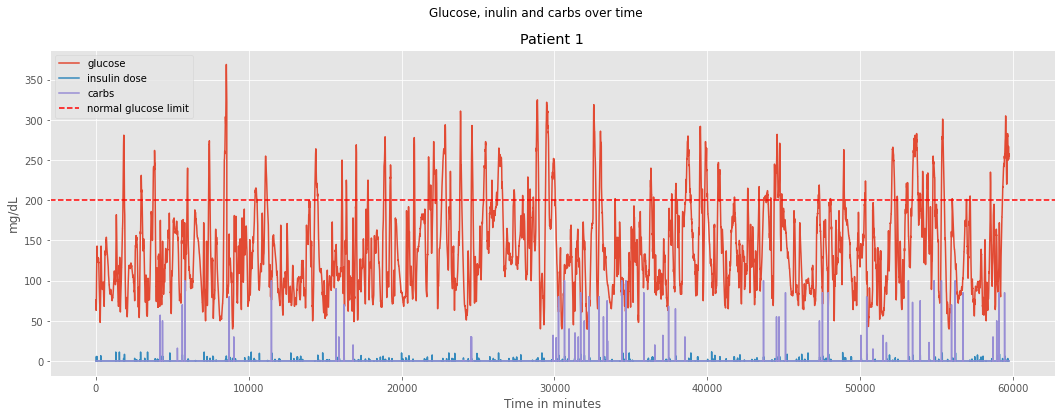

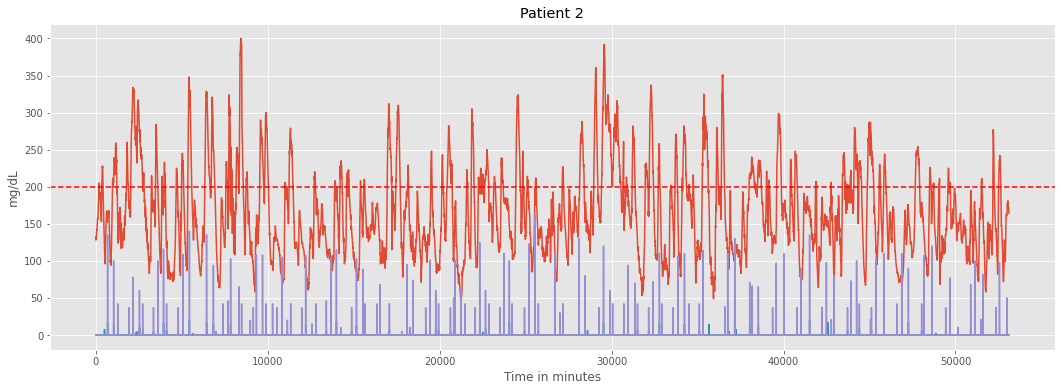

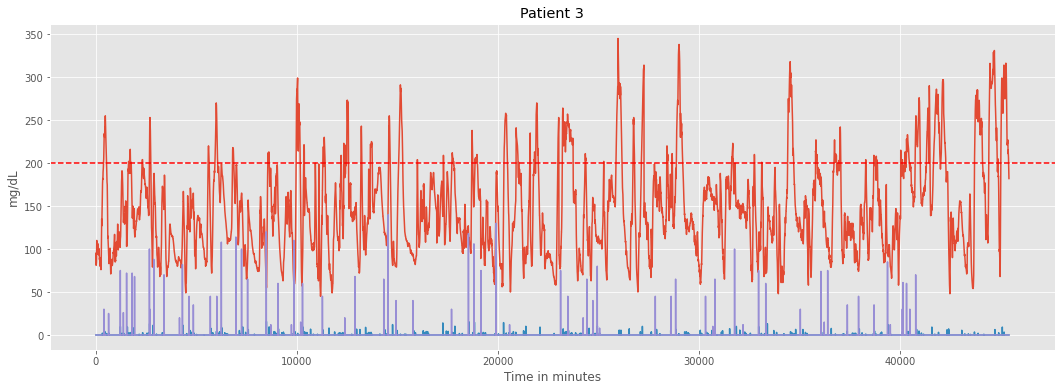

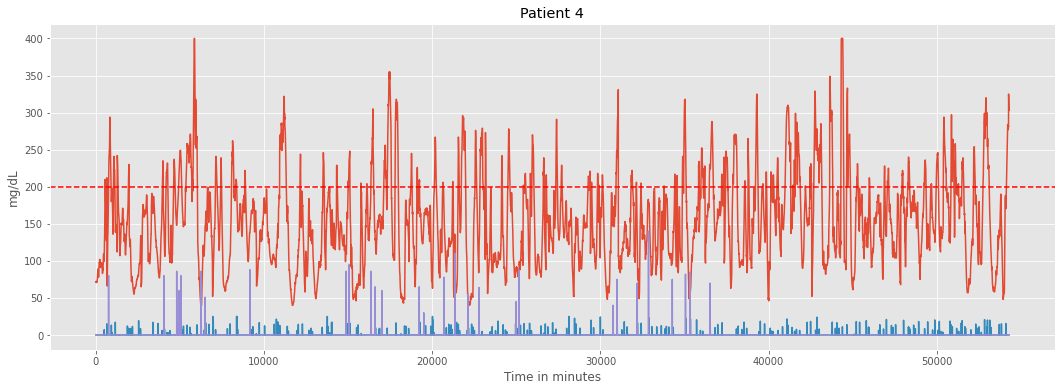

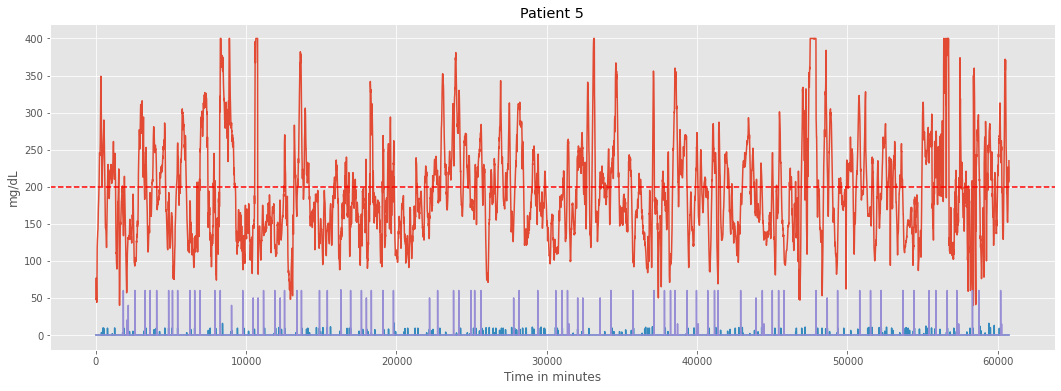

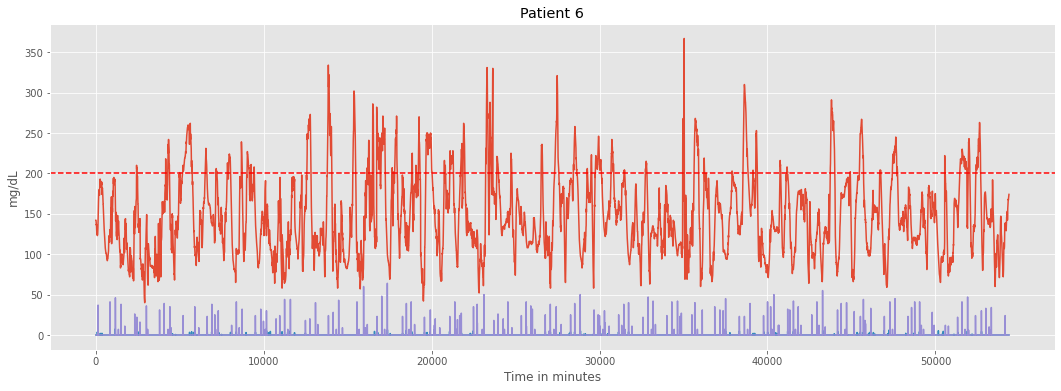

In [14]:
plt.style.use('ggplot')
legend_names = ['glucose','insulin dose','carbs','normal glucose limit',]
for i in range(len(train_dataframes_basal)):

  plt.figure(figsize=(18,6))
  plt.plot(train_dataframes_basal[i]['time'],train_dataframes_basal[i]['glucose'])
  plt.plot(train_dataframes_basal[i]['time'],train_dataframes_basal[i]['dose'])
  plt.plot(train_dataframes_basal[i]['time'],train_dataframes_basal[i]['carbs'])
  plt.xlabel('Time in minutes')
  plt.ylabel('mg/dL')
  plt.axhline(200,color='red',linestyle='--')
  if i == 0:
    plt.legend(labels=legend_names)
    plt.suptitle('Glucose, inulin and carbs over time')
  plt.title(f'Patient {i+1}')
  plt.show()


## plotting test data

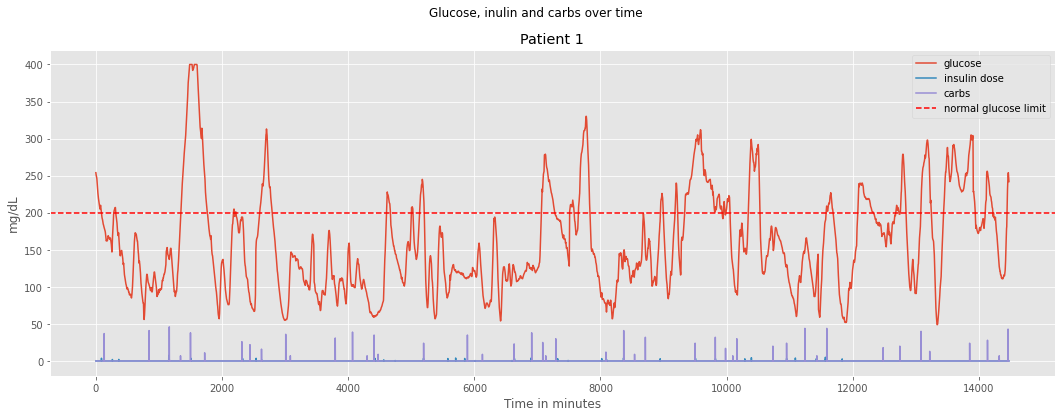

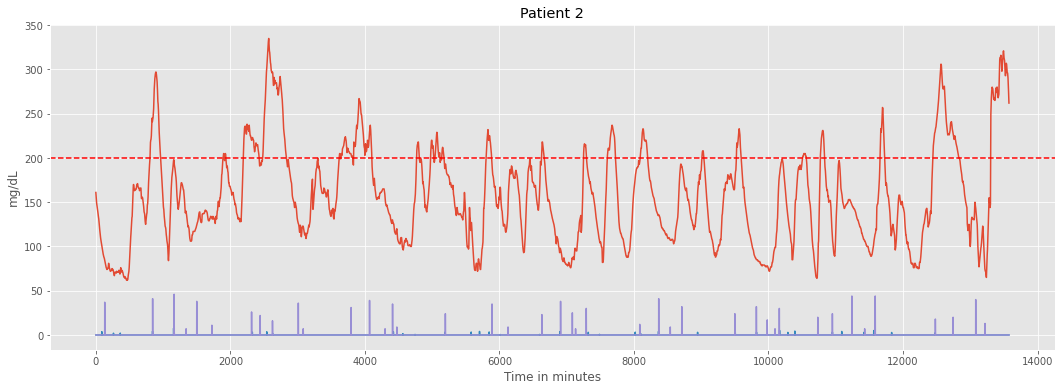

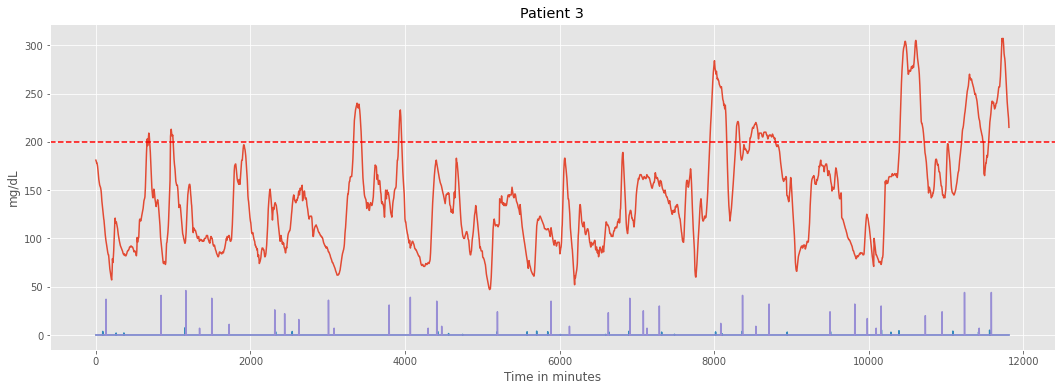

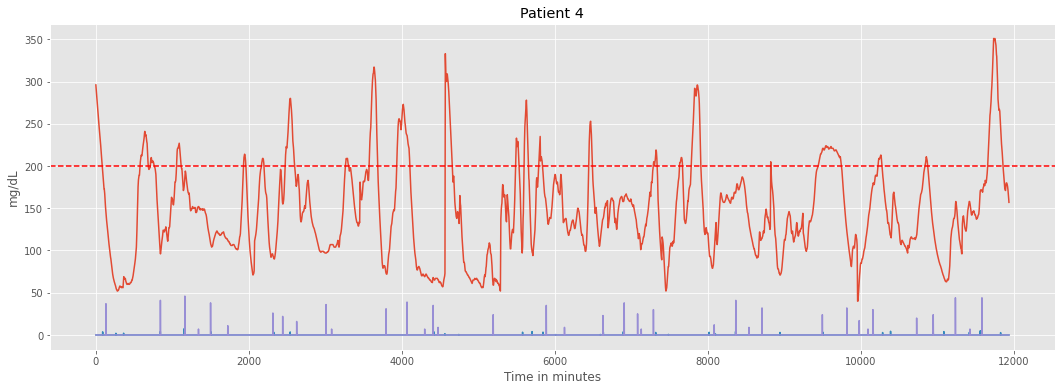

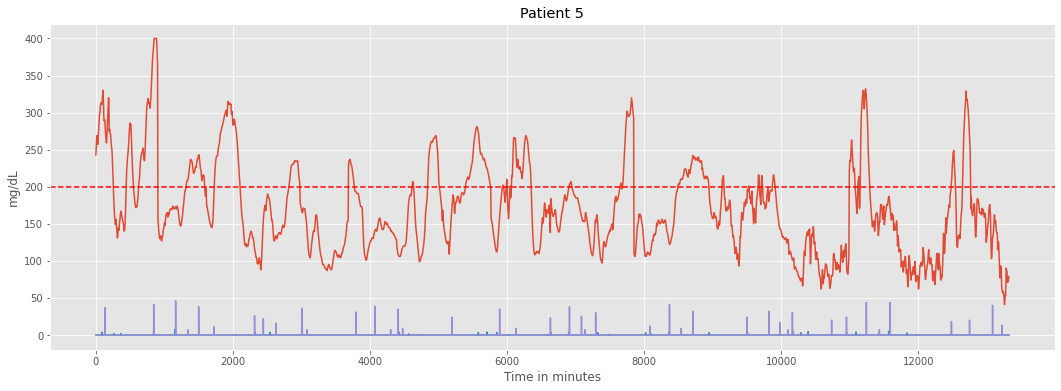

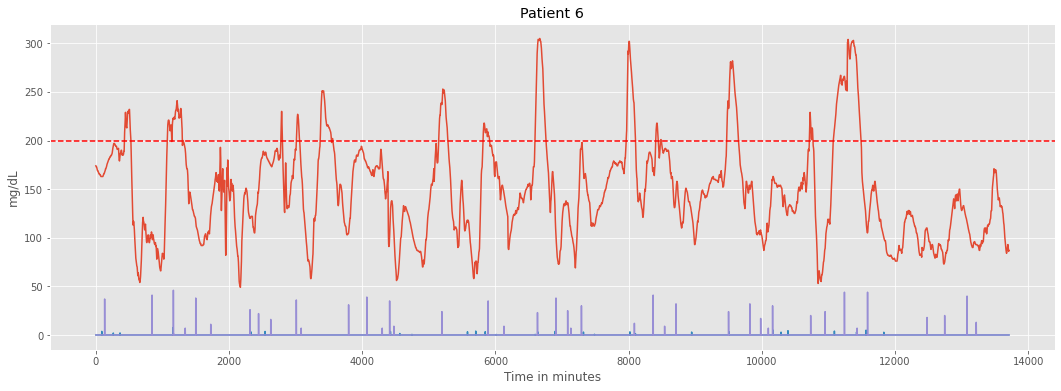

In [15]:
for i in range(len(dataframes_basal_test)):

  plt.figure(figsize=(18,6))
  plt.plot(dataframes_basal_test[i]['time'],dataframes_basal_test[i]['glucose'])
  plt.plot(dataframes_basal_test[i]['time'],dataframes_basal_test[i]['dose'])
  plt.plot(dataframes_basal_test[i]['time'],dataframes_basal_test[i]['carbs'])
  plt.xlabel('Time in minutes')
  plt.ylabel('mg/dL')
  plt.axhline(200,color='red',linestyle='--')
  if i == 0:
    plt.legend(labels=legend_names)
    plt.suptitle('Glucose, inulin and carbs over time')
  plt.title(f'Patient {i+1}')
  plt.show()

## data split

In [16]:
train_dataframes = train_dataframes_basal
test_dataframes = dataframes_basal_test
for i in range(6):
  train_dataframes[i].drop('time',axis=1,inplace=True)
  test_dataframes[i].drop('time',axis=1,inplace=True)

In [17]:
n_prev = 30
input_dim = 4
out_dim = 1
def _load_data(data, n_prev = 30, out_dim = 1):
    """
    takes dataframe, courtesy of Ken
    """
    pred_window = 30
    docX, docY, docTrue = [], [], []
    for i in range(len(data)-n_prev-pred_window):
        docX.append(data.iloc[i:(i + n_prev)].to_numpy())
        docY.append(data.iloc[i + n_prev + pred_window - 1]['glucose'] - data.iloc[i + n_prev - 1]['glucose'])  # here 6 represents 30 minutes
        docTrue.append(data.iloc[i + n_prev + pred_window - 1]['glucose'])
    alsX = np.array(docX)
    alsY = np.array(docY)
    alsZ = np.array(docTrue)
    return alsX, alsY, alsZ

In [18]:
# to input into dataload function
def train_test_split(df_train,df_test):
  X_train, y_train,train_ref = _load_data(df_train,n_prev,out_dim)
  X_test,y_test,test_ref = _load_data(df_test, n_prev, out_dim)
  return (X_train, y_train), (X_test, y_test), (train_ref, test_ref)

In [19]:
X_train,y_train,X_test,y_test,train_ref,test_ref = list(range(6)),list(range(6)),list(range(6)),list(range(6)),list(range(6)),list(range(6))
for i in range(6):
  (X_train[i], y_train[i]), (X_test[i], y_test[i]), (train_ref[i], test_ref[i]) = train_test_split(train_dataframes[i], test_dataframes[i])


In [20]:
X_test[0].shape

(14416, 30, 4)

<Figure size 432x288 with 0 Axes>

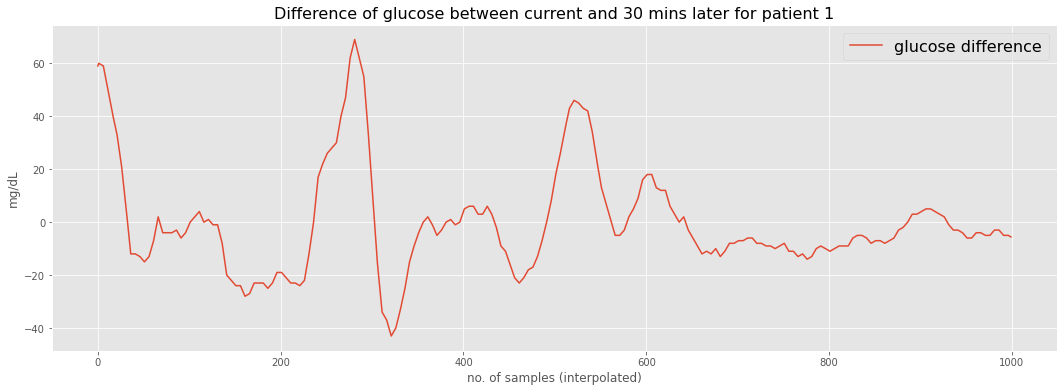

<Figure size 432x288 with 0 Axes>

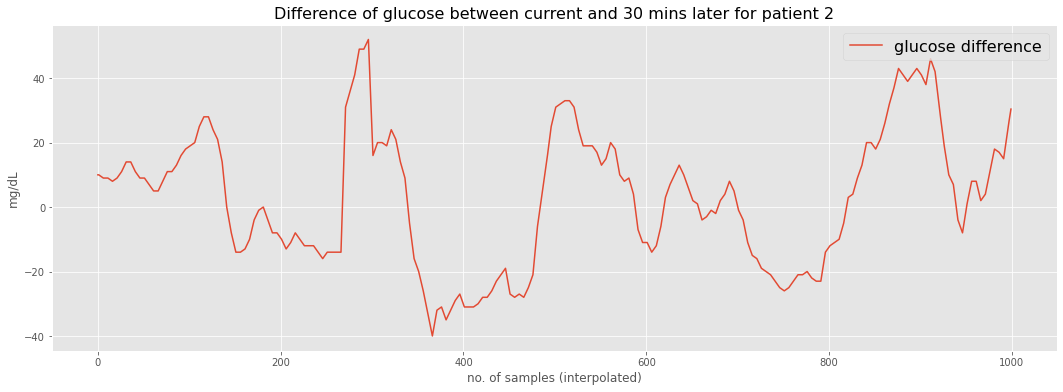

<Figure size 432x288 with 0 Axes>

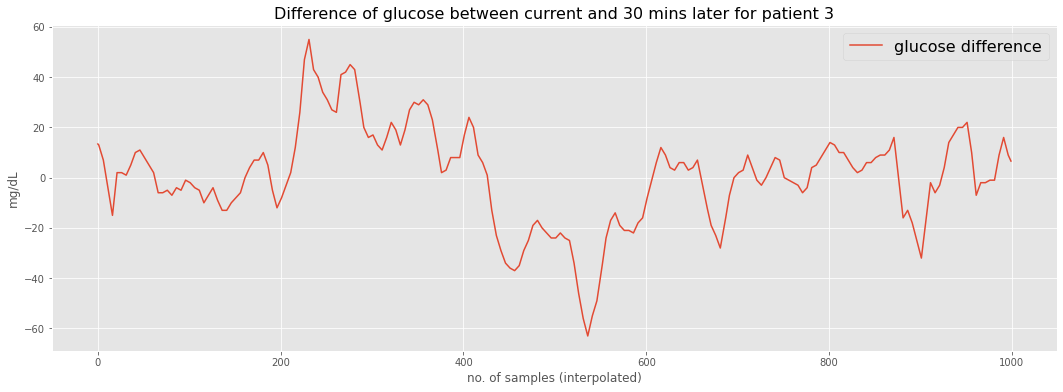

<Figure size 432x288 with 0 Axes>

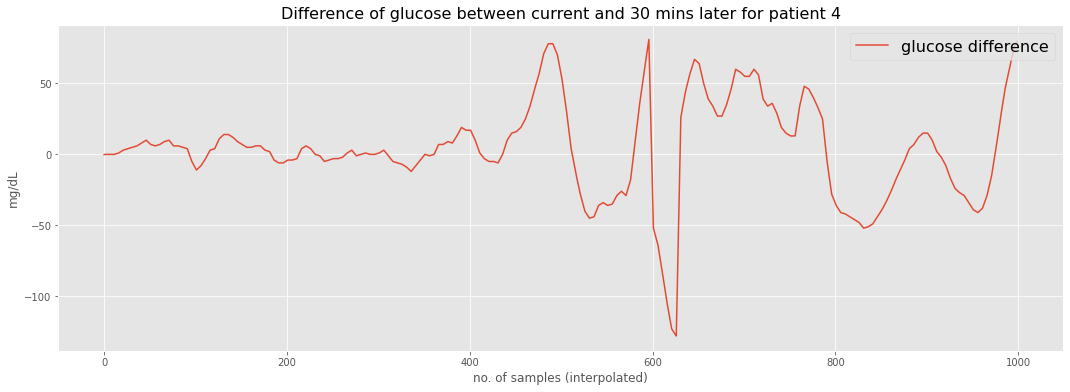

<Figure size 432x288 with 0 Axes>

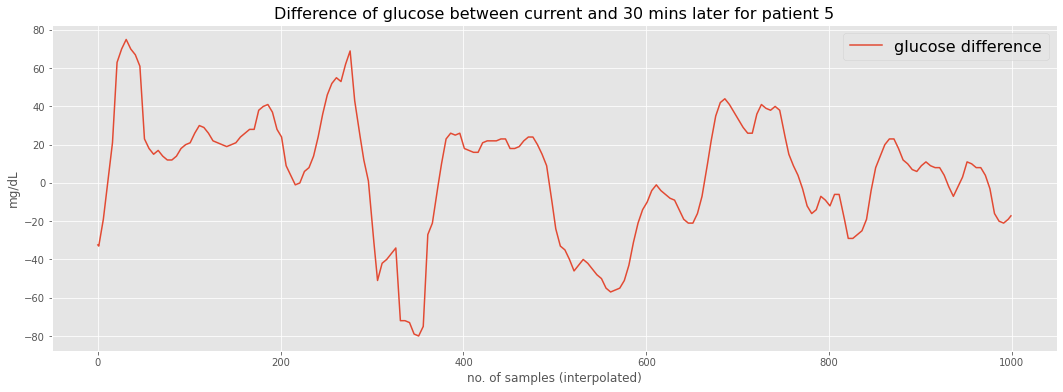

<Figure size 432x288 with 0 Axes>

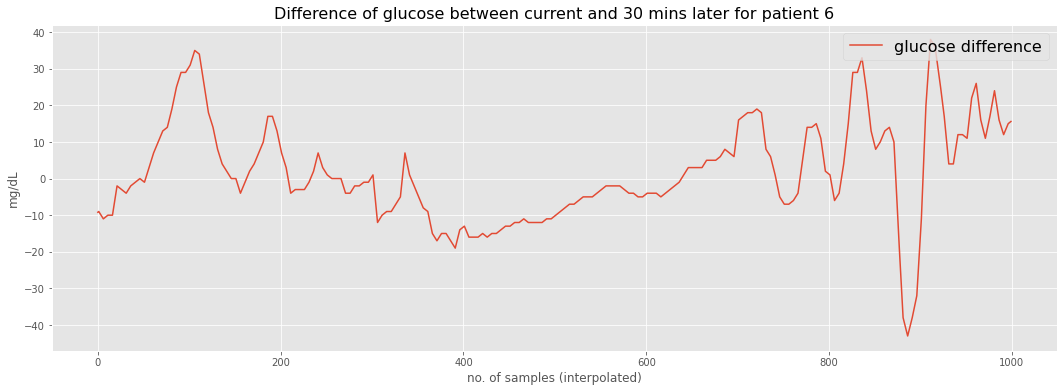

In [21]:
for i in range(6):
  plt.figure()
  plt.figure(figsize=(18,6))
  plt.plot(y_train[i][:1000])
  plt.legend(loc='upper right', fontsize=16, labels=['glucose difference'])
  plt.xlabel('no. of samples (interpolated)')
  plt.ylabel('mg/dL')
  plt.title(f'Difference of glucose between current and 30 mins later for patient {i+1}', fontsize=16)

## modelling SVR

In [35]:
from sklearn.svm import SVR
X_train_svr,X_test_svr = list(range(6)),list(range(6))
# generate X_train_svr, X_test_svr,
for i in range(6):
  X_train_svr[i] = X_train[i][:,0,0]
  X_test_svr[i] = X_test[i][:,0,0]

print("Elements of array: X_train_svr patient 1", X_train_svr[0])

y_train_svr,y_test_svr = list(range(6)),list(range(6))
# generate y_train_svr, y_test_svr
for i in range(6):
  y_train_svr[i] = train_ref[i] # X_train_svr + y_train
  y_test_svr[i] = test_ref[i] #X_test_svr + y_test
  #hi ken! if youre reading this give me good mark!
print('pat 1 y_train_svr shape:', y_train_svr[0].shape)
print('pat 1 y_test_svr shape:', y_test_svr[0].shape)
for i in range(6):
  X_train_svr[i] = X_train_svr[i].reshape([len(X_train_svr[i]),1])
  X_test_svr[i] = X_test_svr[i].reshape([len(X_test_svr[i]),1])

print('pat 1 X_train_svr shape:', X_train_svr[0].shape)
print('pat 1 X_test_svr shape:', X_test_svr[0].shape)

Elements of array: X_train_svr patient 1 [ 76.   75.2  74.4 ... 264.2 263.6 263. ]
pat 1 y_train_svr shape: (59671,)
pat 1 y_test_svr shape: (14416,)
pat 1 X_train_svr shape: (59671, 1)
pat 1 X_test_svr shape: (14416, 1)


In [36]:
X_train_svr[0]

array([[ 76. ],
       [ 75.2],
       [ 74.4],
       ...,
       [264.2],
       [263.6],
       [263. ]])

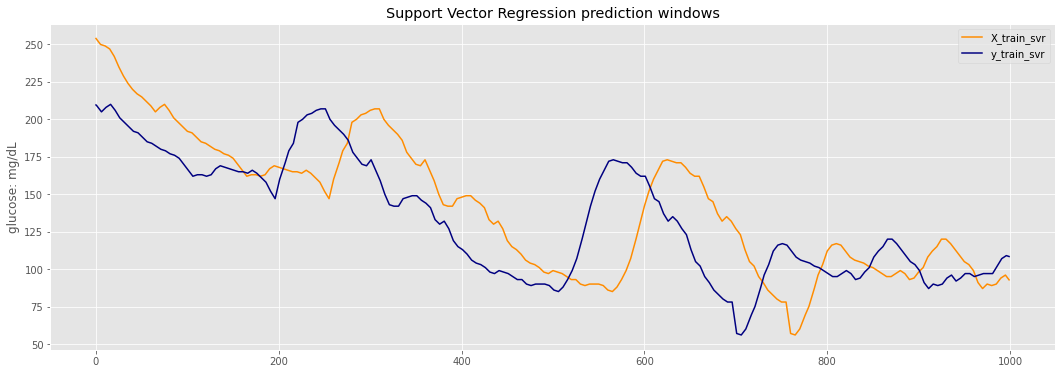

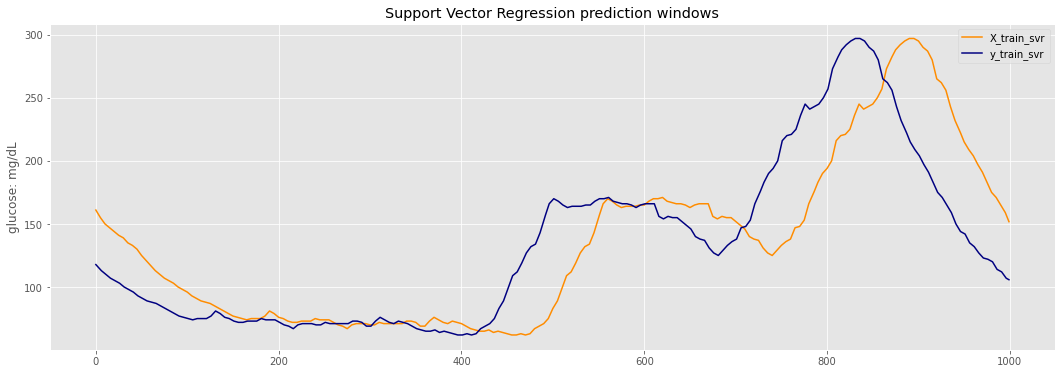

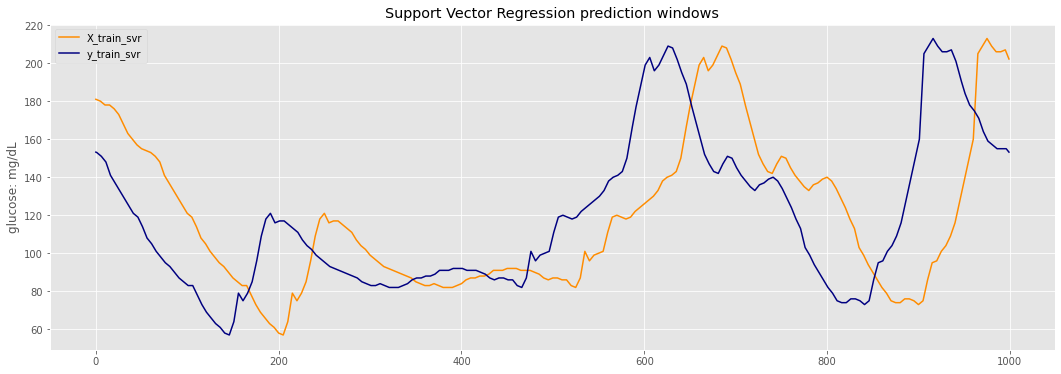

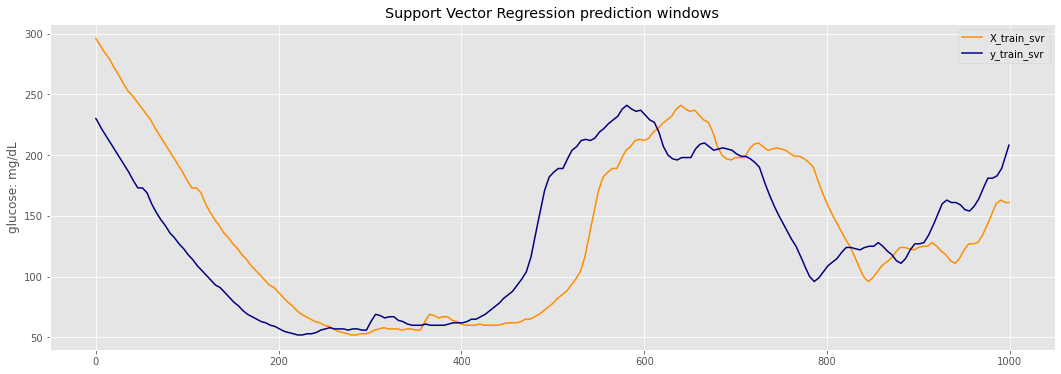

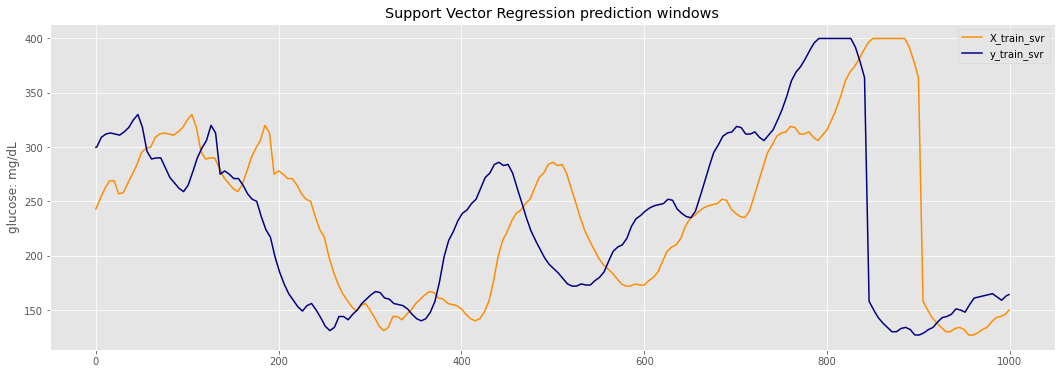

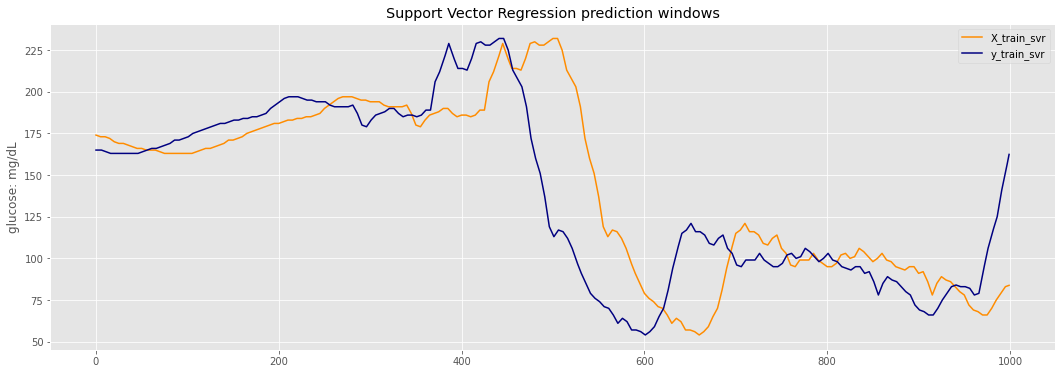

In [38]:
for i in range(6):
  plt.figure(figsize=(18,6))
  plt.plot(X_test_svr[i][:1000], color='darkorange', label='X_train_svr')
  plt.plot(y_test_svr[i][:1000], color='navy', label='y_train_svr')
  plt.ylabel('glucose: mg/dL')
  plt.title('Support Vector Regression prediction windows')
  plt.legend()
  plt.show()

In [39]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
# rmse = mean_squared_error(X_test_svr, y_rbf, squared=False)
# scorer = make_scorer(rmse, greater_is_better=False)
# svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)



### halvinggridsearch takes ages. uncomment this code at your own peril. but it does produce a nice dataframe which has relative 'scores' for each set of hyperparameters making seleciton easy.

In [40]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
# svr_rbf = SVR(kernel='rbf', C=0.1e3, gamma=0.01,cache_size=1000)
# normalize_para=100
# param_grid = {'kernel':['rbf'],
#               'epsilon':[0.1,0.2,0.3],
#               'gamma':[0.001,0.01,0.1],
#               'C':[0.1e3,0.2e3],
#               'cache_size':[1000]}
# cv = KFold(n_splits=5)
# scoring = make_scorer('neg_root_mean_squared_error',greater_is_better=False)
# df_grid_results = pd.DataFrame()
# grid_search = HalvingGridSearchCV(SVR(),
#         param_grid=param_grid, 
#         scoring='neg_mean_squared_error', 
#         cv=cv, 
#         n_jobs=1, 
#         verbose=10,)
# for i in range(6):

#     # run the grid search
    
#     grid_search.fit(X_train_svr[i], y_train_svr[i])
    
#     # save the grid search results in the data frame
#     df_temp = pd.DataFrame(grid_search.cv_results_)
#     df_temp['dataset'] = i
    
#     df_grid_results = df_grid_results.append(df_temp, ignore_index=True)

# df_grid_results = df_grid_results.set_index(df_grid_results['params'].apply(lambda x: '_'.join(str(val) for val in x.values()))).rename_axis('kernel')

In [41]:
# df_grid_results.sort_values(by=['split0_train_score','dataset'])

In [42]:
# pd.options.display.max_rows = 999

# df_grid_results.sort_values(by=['dataset','rank_test_score'])

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_svr_norm,y_train_svr_norm,X_test_svr_norm,y_test_svr_norm = list(range(6)),list(range(6)),list(range(6)),list(range(6))
for i in range(6):
    X_train_svr_norm[i]=scaler.fit_transform(X_train_svr[i].reshape(-1,1))
    y_train_svr_norm[i]=scaler.fit_transform(y_train_svr[i].reshape(-1,1))
    X_test_svr_norm[i]=scaler.fit_transform(X_test_svr[i].reshape(-1,1))
    y_test_svr_norm[i]=scaler.fit_transform(y_test_svr[i].reshape(-1,1))

In [45]:
#the above results show each models best results per patient
models = [SVR(kernel='rbf',gamma=0.1,cache_size=1000,C=200,epsilon=0.1),
          SVR(kernel='rbf',gamma=0.1,cache_size=1000,C=200,epsilon=0.1),
          SVR(kernel='rbf',gamma=0.1,cache_size=1000,C=200,epsilon=0.1),
          SVR(kernel='rbf',gamma=0.1,cache_size=1000,C=200,epsilon=0.1),
          SVR(kernel='rbf',gamma=0.1,cache_size=1000,C=100,epsilon=0.1),
          SVR(kernel='rbf',gamma=0.1,cache_size=1000,C=200,epsilon=0.2)]

svr_rbf = SVR(kernel='rbf', C=200, gamma=0.1,cache_size=1000,epsilon=0.3)

In [46]:
# fit model
y_rbf=list(range(6))
for i in range(6):
  y_rbf[i] = models[i].fit(X_train_svr_norm[i], y_train_svr_norm[i]).predict(X_test_svr_norm[i])

In [47]:
unscaled_y_rbf,unscaled_y_test_svr = list(range(6)),list(range(6))
for i in range(6):
    unscaled_y_rbf[i] = scaler.inverse_transform(y_rbf[i].reshape(1,-1))
    unscaled_y_test_svr[i] = scaler.inverse_transform(y_test_svr_norm[i].reshape(1,-1))

In [48]:
unscaled_y_rbf[0][0]

array([180.1955943 , 179.7361491 , 179.27569228, ..., 106.8078497 ,
       107.12570006, 107.44619482])

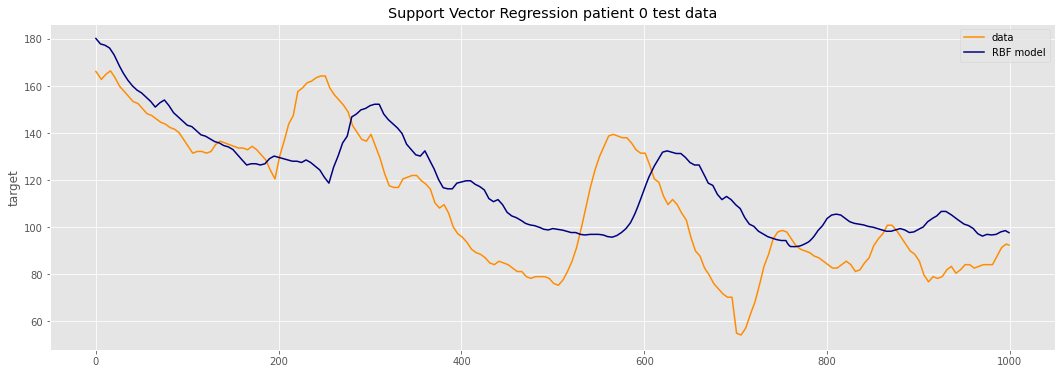

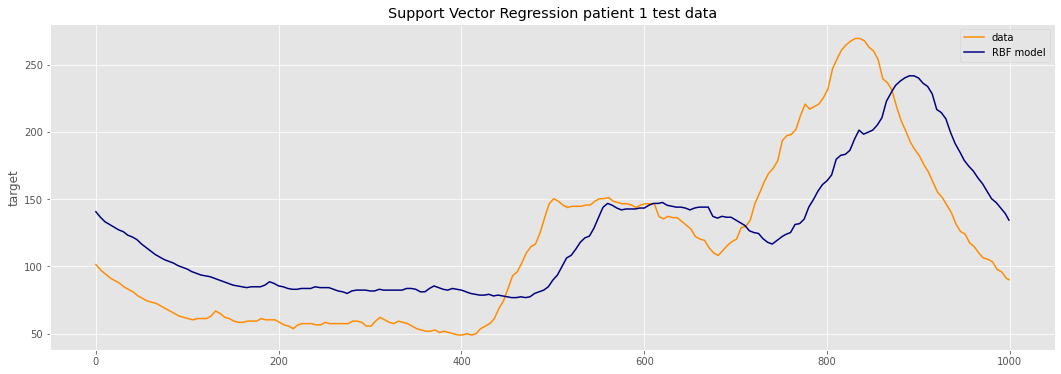

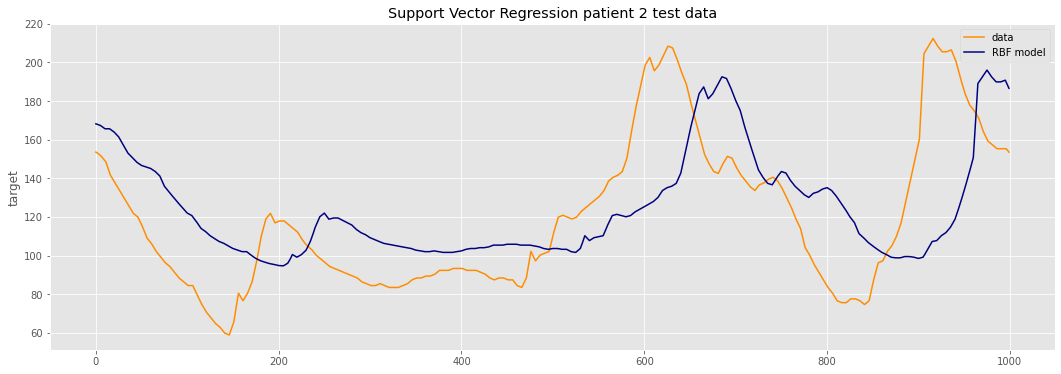

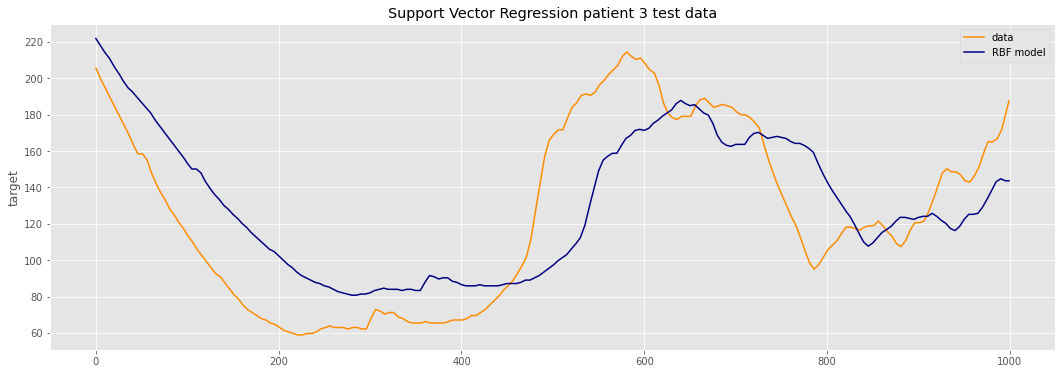

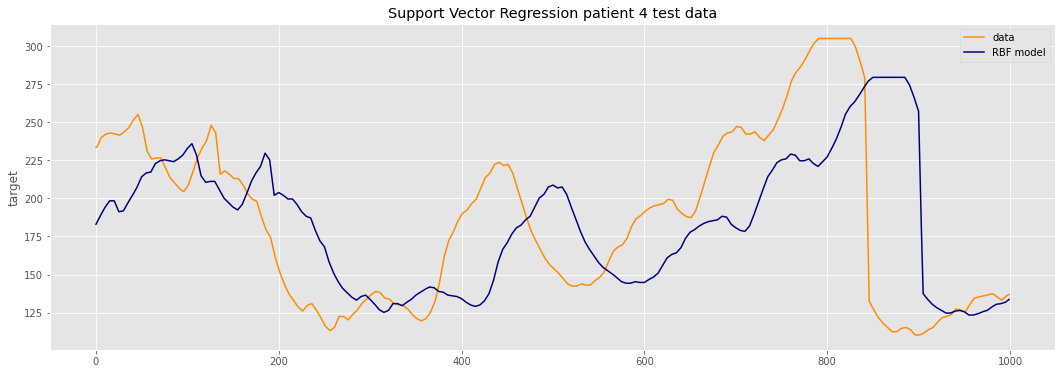

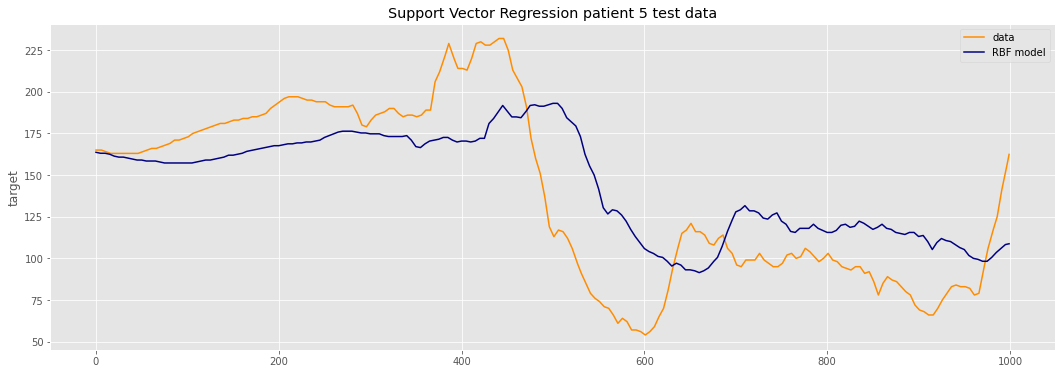

In [49]:
for i in range(6):  
  plt.figure(figsize=(18,6))
  plt.plot(unscaled_y_test_svr[i][0][:1000], color='darkorange', label='data')
  plt.plot(unscaled_y_rbf[i][0][:1000], color='navy', label='RBF model')
  plt.ylabel('target')
  plt.title(f'Support Vector Regression patient {i} test data')
  plt.legend()
  plt.show()

In [50]:
 rmse_result, MARD = list(range(6)),list(range(6))
 for i in range(6):
  rmse_result[i] = np.sqrt(np.mean((unscaled_y_rbf[i] - unscaled_y_test_svr[i])**2))
  MARD[i] = np.mean(np.abs((unscaled_y_test_svr[i] - unscaled_y_rbf[i])/unscaled_y_test_svr[i]))
  # mape[i] = 1/
  print('patient {} RMSE:{}'.format(i+1,rmse_result[i]))
  print('patient {} MARD:{}'.format(i+1,MARD[i]*100))

patient 1 RMSE:32.48940577041873
patient 1 MARD:21.914974992758065
patient 2 RMSE:33.226373969795446
patient 2 MARD:21.38492151665863
patient 3 RMSE:31.791741342535882
patient 3 MARD:18.844240661096233
patient 4 RMSE:35.898718741818314
patient 4 MARD:21.009524207349017
patient 5 RMSE:30.864584114339745
patient 5 MARD:18.0360559543559
patient 6 RMSE:34.54744987844581
patient 6 MARD:20.07799183236844


In [101]:
#sensitivity for predicting hypo or hyperglyceamia. WIP
for i in range(6):
  hyper_count_pred = 0
  hyper_count_true = 0
  hypo_count_pred = 0
  hypo_count_true = 0
  for j in range(len(unscaled_y_test_svr[i][0])):

    if unscaled_y_test_svr[i][0][j] > 200:
      hyper_count_true += 1
    if unscaled_y_rbf[i][0][j] > 200:
      hyper_count_pred += 1
  

    if unscaled_y_rbf[i][0][j] < 70:
      hypo_count_pred += 1
    if unscaled_y_test_svr[i][0][j] < 70:
      hypo_count_true += 1

  hypo_acc = (hypo_count_pred/hypo_count_true)*100
  print(f'patient{i} hypo acc: ',hypo_acc)
  hyper_acc = (hyper_count_pred/hyper_count_true)*100
  print(f'patient{i} hyper acc: ',hyper_acc)
#colab did not autosave and reverted in the last hours have no time to finish the accuracy/sensitivity analysis for either model
#can discuss this as future project

patient0 hypo acc:  0.0
patient0 hyper acc:  44.71858134155744
patient1 hypo acc:  0.0
patient1 hyper acc:  53.51925630810093
patient2 hypo acc:  0.0
patient2 hyper acc:  63.762019230769226
patient3 hypo acc:  0.0
patient3 hyper acc:  50.452488687782804
patient4 hypo acc:  0.0
patient4 hyper acc:  71.32075471698113
patient5 hypo acc:  0.0
patient5 hyper acc:  34.76112026359143


## neural network

In [52]:
input_dim = 4
n_prev = 30
n_batch   = 64
n_epoch   = 30
nb_lstm_outputs  = 64
nb_output        = 1
prob_drop_conv   = 0.1 
prob_drop_hidden = 0.3
out_dim   = 1

In [53]:
# build network
model = Sequential()

model.add(layers.Bidirectional(layers.LSTM(nb_lstm_outputs, return_sequences=False),input_shape = (n_prev, input_dim)))
model.add(layers.Dropout(prob_drop_hidden))


model.add(layers.Dense(256, activation = 'linear'))
model.add(layers.Dropout(prob_drop_hidden))


model.add(layers.Dense(32, activation = 'linear'))
model.add(layers.Dropout(prob_drop_hidden))


model.add(layers.Dense(out_dim, activation = 'linear'))

opt = RMSprop(lr=0.003, rho=0.9) 
# # opt = Adam(lr=0.0003)
rmse = tf.keras.metrics.RootMeanSquaredError()
model.compile(optimizer = opt, loss = 'mse', metrics = ['mae',rmse])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              35328     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                        

In [55]:
X_train[0] = (X_train[0]/100)

In [56]:
X_train[1] = (X_train[1]/100)
X_train[2] = (X_train[2]/100)
X_train[3] = (X_train[3]/100)
X_train[4] = (X_train[4]/100)
X_train[5] = (X_train[5]/100)
X_test[1] = (X_test[1]/100)
X_test[2] = (X_test[2]/100)
X_test[3] = (X_test[3]/100)
X_test[4] = (X_test[4]/100)
X_test[5] = (X_test[5]/100)
X_test[0] = (X_test[0]/100)
y_train[1] = (y_train[1]/100)
y_train[2] = (y_train[2]/100)
y_train[3] = (y_train[3]/100)
y_train[4] = (y_train[4]/100)
y_train[5] = (y_train[5]/100)
y_train[0] = (y_train[0]/100)

In [57]:
# apologies for keeping the crnn variable name from the practical! had to rush to re-do this entire section
history_crnn = list(range(6))
# # earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, verbose=1, mode='min')
# mcp_save = tf.keras.callbacks.ModelCheckpoint(f'{i}.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# # reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

# # swap to the first optimiser, make epochs=5 and change batch to 32 for this to be very fast with almost as good results (reaching as low as 18.5 mae for patient 1)
# with tf.device('/cpu:0'):
#     for i in range(6):
#       history_crnn[i] = model.fit(X_train[i], y_train[i], batch_size = n_batch, epochs = n_epoch, validation_split = 0.05)

In [58]:

history_crnn[0] = model.fit(X_train[0], y_train[0], batch_size = n_batch, epochs = n_epoch, validation_split = 0.05)

Epoch 1/30
886/886 [==============================] - 39s 39ms/step - loss: 0.0846 - mae: 0.1963 - root_mean_squared_error: 0.2909 - val_loss: 0.0614 - val_mae: 0.1969 - val_root_mean_squared_error: 0.2477
Epoch 2/30
886/886 [==============================] - 34s 38ms/step - loss: 0.0613 - mae: 0.1808 - root_mean_squared_error: 0.2476 - val_loss: 0.0604 - val_mae: 0.1955 - val_root_mean_squared_error: 0.2458
Epoch 3/30
886/886 [==============================] - 35s 40ms/step - loss: 0.0577 - mae: 0.1747 - root_mean_squared_error: 0.2403 - val_loss: 0.0550 - val_mae: 0.1868 - val_root_mean_squared_error: 0.2346
Epoch 4/30
886/886 [==============================] - 33s 37ms/step - loss: 0.0546 - mae: 0.1693 - root_mean_squared_error: 0.2336 - val_loss: 0.0557 - val_mae: 0.1861 - val_root_mean_squared_error: 0.2360
Epoch 5/30
886/886 [==============================] - 33s 37ms/step - loss: 0.0526 - mae: 0.1663 - root_mean_squared_error: 0.2293 - val_loss: 0.0659 - val_mae: 0.2008 - val_ro

dict_keys(['loss', 'mae', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_root_mean_squared_error'])


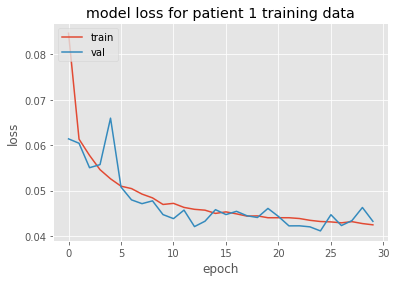

AttributeError: ignored

In [60]:
# history
for i in range(1):
  print(history_crnn[i].history.keys())
# history for loss
for i in range(6):
  plt.plot(history_crnn[i].history['loss'])
  plt.plot(history_crnn[i].history['val_loss'])
  plt.title(f'model loss for patient {i+1} training data')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [61]:
y_crnn = list(range(6))
for i in range(6):
  y_crnn[i]= model.predict(X_test[i])

In [69]:
y_crnn_renorm = list(range(6))
for i in range(6):
  y_crnn_renorm[i] = (X_test[i][:,-1,0] + y_crnn[i].T)*100
  y_crnn_renorm[i] = [item for sublist in y_crnn_renorm[i] for item in sublist]


[209.7481637120247,
 208.18910533189774,
 207.6462923288345,
 207.3152561187744,
 206.3564205765724,
 205.23294508457184,
 204.12577295303348,
 203.98829795122145,
 204.03254857063297,
 203.3365691065788,
 202.47999833822252,
 201.69112950563434,
 201.86134370565415,
 202.22709541320802,
 201.81736983060836,
 201.2571127176285,
 200.82621258497238,
 201.3354993224144,
 202.01214249134063,
 201.89371334314345,
 201.62636944055555,
 201.50914877653122,
 200.3730452299118,
 199.0334827184677,
 198.49148548841472,
 198.1643779039383,
 197.7040748000145,
 197.282431268692,
 196.84836165905,
 196.3697569489479,
 195.76499304771426,
 195.1272156238556,
 193.5184625506401,
 191.71607782840726,
 190.71796391010284,
 189.9157749295235,
 189.01737362146375,
 195.14352736473083,
 202.80385772585868,
 204.54039033800365,
 202.93726464509962,
 202.94075551629066,
 203.8382061958313,
 204.40583904385568,
 204.96160088181497,
 206.25958955883982,
 207.63830099254847,
 203.1156621694565,
 197.821036094

In [71]:
 rmse_result, MARD = list(range(6)),list(range(6))
 for i in range(6):
  rmse_result[i] = np.sqrt(np.mean((test_ref[i] - y_crnn_renorm[i])**2))
  MARD[i] = np.mean(np.abs(100*(test_ref[i] - y_crnn_renorm[i])/y_crnn_renorm[i]))

  print('patient {} RMSE:{}'.format(i+1,rmse_result[i]))
  print('patient {} MARD:{}'.format(i+1,MARD[i]))

patient 1 RMSE:26.08976344377757
patient 1 MARD:12.156459498661588
patient 2 RMSE:18.74585980890695
patient 2 MARD:9.402985872512662
patient 3 RMSE:16.170970104687672
patient 3 MARD:9.3345998722123
patient 4 RMSE:25.1883819939714
patient 4 MARD:12.548017385564993
patient 5 RMSE:26.47200869070822
patient 5 MARD:11.25147271854239
patient 6 RMSE:17.37431698996665
patient 6 MARD:8.983541264143577


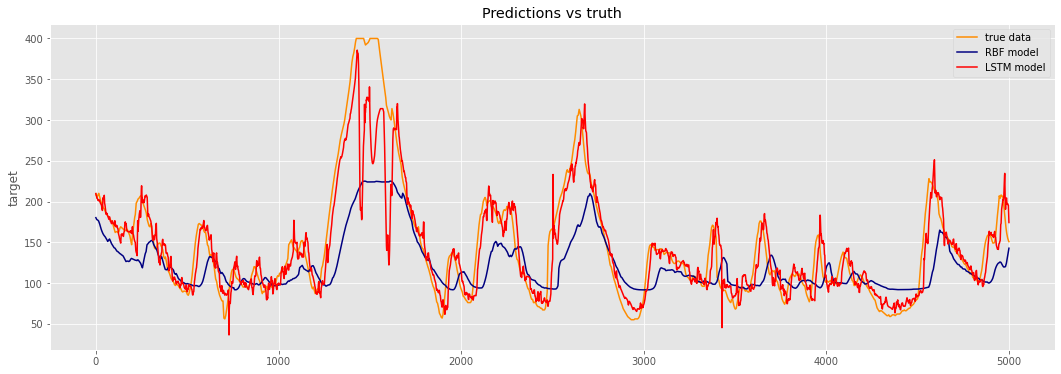

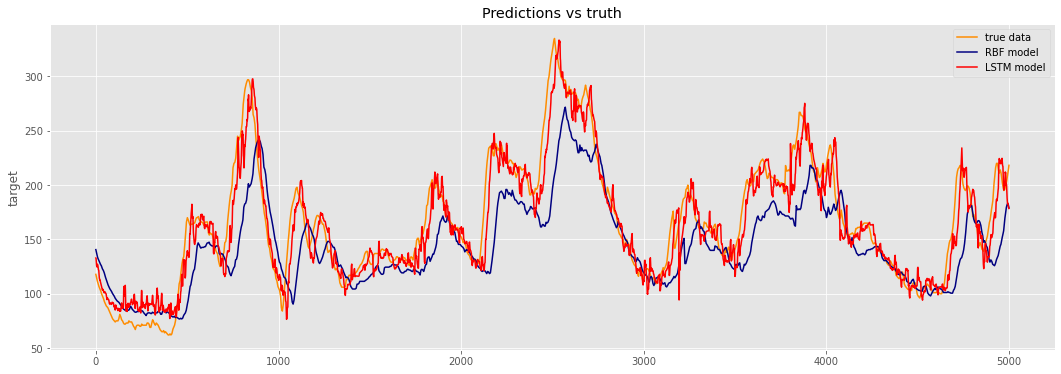

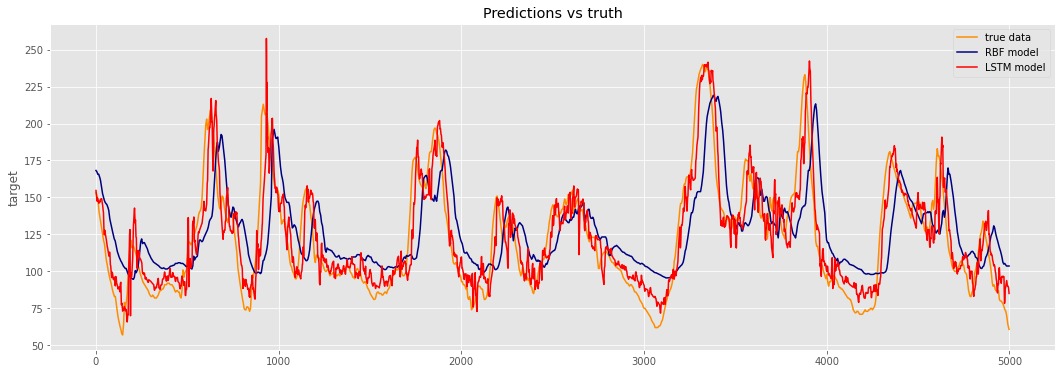

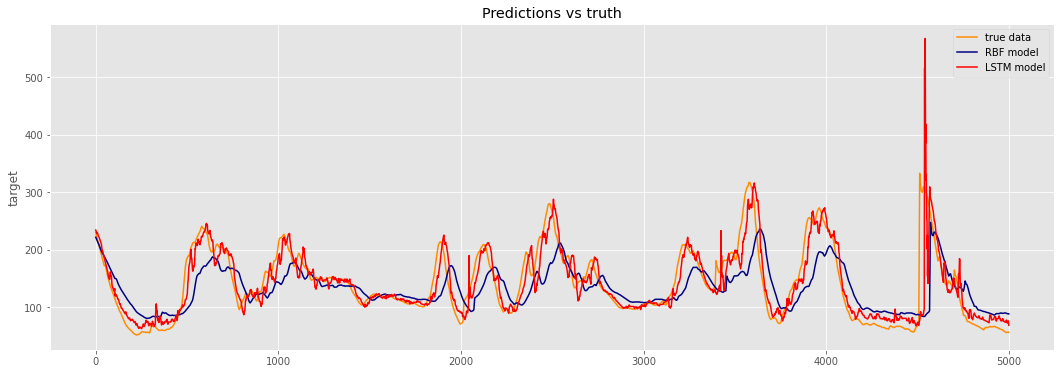

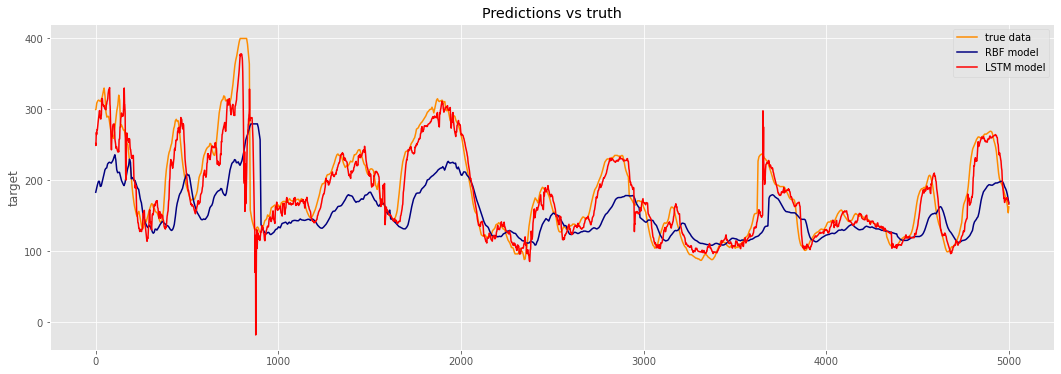

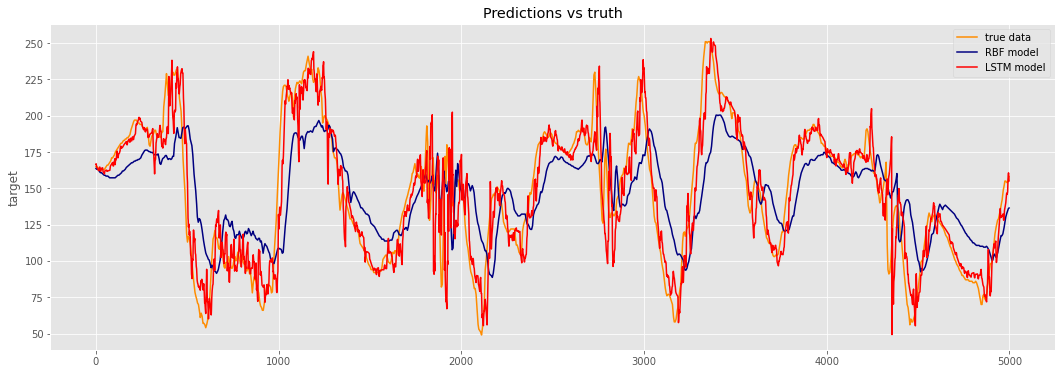

In [85]:
for i in range(6):
  plt.figure(figsize=(18,6))
  plt.plot(test_ref[i][:5000], color='darkorange', label='true data')
  plt.plot(unscaled_y_rbf[i][0][:5000], color='navy', label='RBF model')
  plt.plot(y_crnn_renorm[i][:5000], color='red', label='LSTM model')
  plt.ylabel('target')
  plt.title('Predictions vs truth')
  plt.legend()
  plt.show()

In [80]:
unscaled_y_rbf[0]

array([[180.1955943 , 179.7361491 , 179.27569228, ..., 106.8078497 ,
        107.12570006, 107.44619482]])